In [1]:
from util import *


# Basic Correlation & Strategy Notebook

Purposes of this notebook:
1. Explore basic correlations between our feature variables and target variables (sentiment, absolute sentiment over different periods vs future log returns over various target horizons). In sample (pre-2022).
2. Explore trading strategies involving those sentiment metrics (in sample), compare vs equivalent buy and hold.
3. Explore correlation between aggregate sentiment scores versus overall market returns, plus trading strategies.

In [2]:
# Change to directory of dataset file
# Dataset file is guaranteed to have all days for all stocks, i.e. shift(30) is guaranteed to be 30 calendar days
# This leaves a lot of NaNs to be filled
path = "~/s3local/sentimentgroup/datasets/roberta.parquet"

In [3]:
# Horizons to calculate future returns (e.g. price after N days)
target_horizons = [10, 30, 90]
# Horizons to calculate lookbacks for rolling means (e.g. mean sentiment over last N days)
lookback_periods = [10, 30, 90]
# Enable to add residualised returns as a target 
# Also known as idiosyncratic returns, ie individual stock returns after removing overall market trends 
# Takes about 60 seconds per target horizon, so disable if not needed
residualise_returns = False

# Date range, leave None to use all available data (where we have prices)
start_date = "2014-01-01"
end_date = "2022-01-01" # Keep out of sample for now
df = load_dataset(
    path,
    target_horizons = target_horizons,
    lookback_periods = lookback_periods,
    residualise_returns = residualise_returns,
    start_date=start_date,
    end_date=end_date
)

100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


*Analysing correlations between signals and target returns.*

We are trying to see which input features have the strongest predictive effect in sample (pre 2022) and use those correlations to inform a basic trading strategy.

In [4]:
df["ft_past_returns_30"] = df.groupby("symbol")["close"].pct_change(30).reset_index(0, drop=True)
df['ft_close'] = df.close

Example plot of one of the features, and price over time.

/var/folders/xm/c6vg066d2kn3ls17c4f937500000gn/T/ipykernel_72256/2321218839.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  t = df[df.symbol == 'AAPL'][df.dt > datetime(2017, 1, 1)].copy()


<Axes: xlabel='dt'>

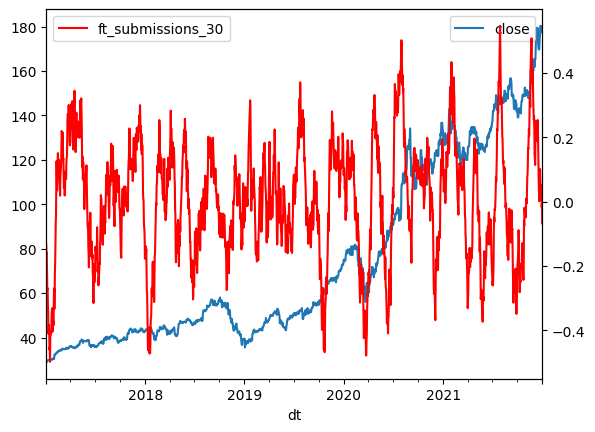

In [55]:
t = df[df.symbol == 'AAPL'][df.dt > datetime(2017, 1, 1)].copy()
ax = t.plot(x='dt', y='close')
t.plot(x='dt', y='ft_submissions_30', ax=ax.twinx(), style='r-')


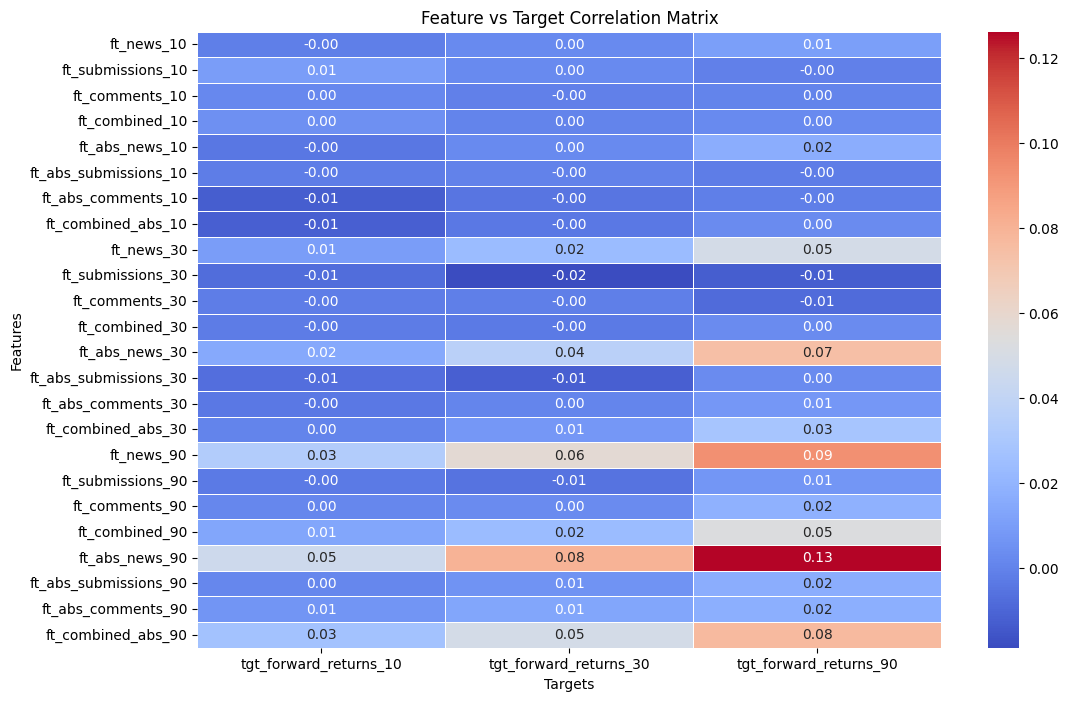

In [54]:
plot_feature_target_correlation(df[df.dt > datetime(2017, 1, 1)], exclude=["ft_news", "ft_submissions", "ft_comments", "ft_combined", "ft_abs_news", "ft_abs_submissions", "ft_abs_comments", "ft_combined_abs"])

array([[<Axes: title={'center': 'ft_abs_news_90'}>]], dtype=object)

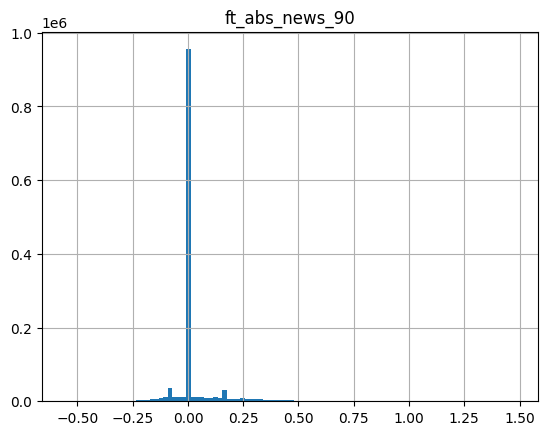

In [7]:
df[['ft_abs_news_90']].hist(bins=100)

Notes:
- Stronger correlation at larger horizons.
- Stronger correlation on the abs(sentiment) features than actual sentiment. 
- No correlation on regular positive/negative reddit features, likely due to hard to interpret (swearing, etc)
- No correlation on past returns/close price, hopefully shows theres not some inherent bias with the data

Here are some example csvf plots to show the usage

Forward returns (10 day) vs mean submission sentiment in last 10 days.
If there were no correlation at all, the blue line would lie exactly on top of the red dotted line.
In the bottom left we can see (-0.4 to -0.2) that the target cumsum is below cs_trades - this shows that the average returns at lower sentiment were smaller, and at the top right (sentiment 0.1 to 0.2) we see that the blue line crossed above the red line, indicating that returns there were larger.

Csvf plots aren't super sciencey, think of it as a sum of returns (i.e pnl) vs our feature. If we can find regions in the X axis where pnl goes up a lot, we should buy, if it goes down a lot, we want to sell. The fact these two lines are very similar shows how small correlations are, this isn't discouraging, if we could see huge differences it would suggest something was wrong.

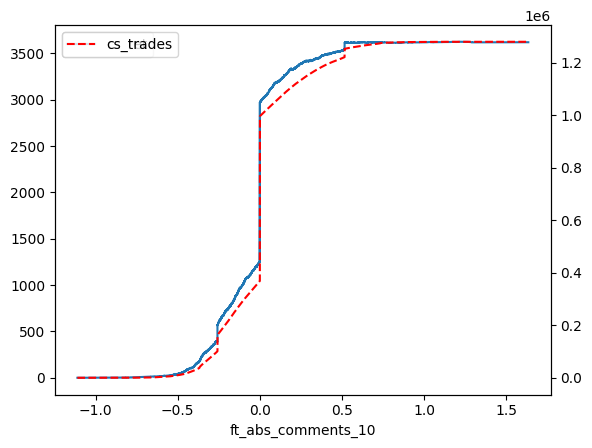

In [8]:
csvf_plot(df, "ft_abs_comments_10", "tgt_forward_returns_10")

In [14]:

news_fts = [c for c in df.columns if c.startswith('ft_news') and not (c.endswith('_90'))]
submissions_fts = [c for c in df.columns if c.startswith('ft_submissions') and not (c.endswith('_90'))]
comments_fts = [c for c in df.columns if c.startswith('ft_comments') and not (c.endswith('_90'))]

In [13]:
train = df[df.dt < datetime(2018, 10, 1)].copy()
val = df[df.dt >= datetime(2019, 2, 1)].copy()

In [17]:
from sklearn.linear_model import Ridge

In [40]:
m = Ridge()
m.fit(train[news_fts+submissions_fts+comments_fts], train['tgt_forward_returns_10'] )
val['pred'] = m.predict(val[news_fts+submissions_fts+comments_fts]).clip(0, None)

In [41]:
pearsonr(val.pred, val.tgt_forward_returns_10)

PearsonRResult(statistic=0.00470063053876813, pvalue=0.0006031740699069848)

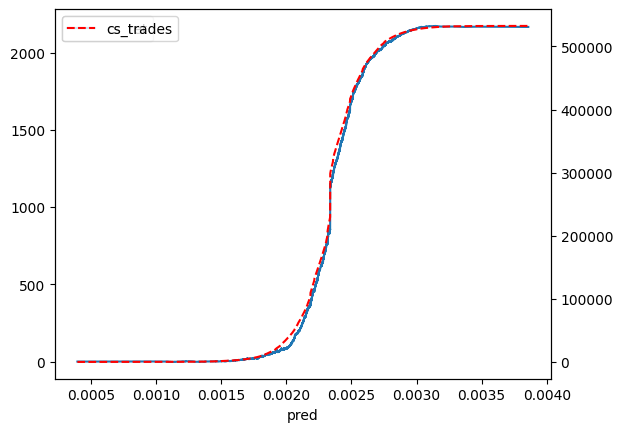

In [42]:
csvf_plot(val, 'pred', 'tgt_forward_returns_10')

In [52]:
val['signal'] = np.where(val.pred > 0.002, 1, 0)
# val['signal'] = 1
port, pos = simulate_portfolio_vectorized(val, tc_rate=0)

In [10]:
df['signal'] = 1

In [44]:
port, pos = simulate_portfolio_vectorized(df, tc_rate=0)

<Axes: xlabel='date'>

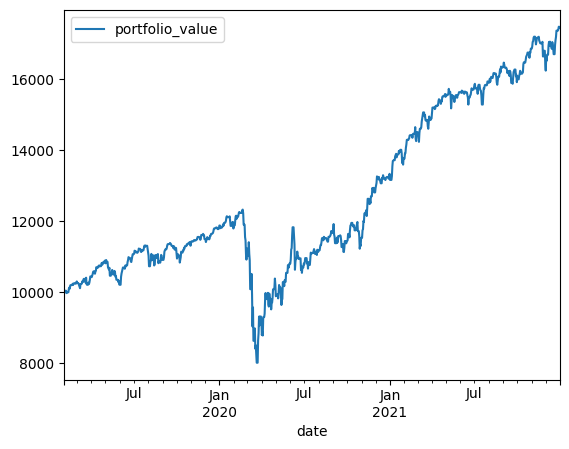

In [53]:
port.reset_index().plot(x='date', y='portfolio_value')


In [ ]:
df['signal'] = df.ft_abs_submissions_90

In [60]:

df['signal'] = df['ft_comments_30'].fillna(0).clip(0)
# df['signal'] = df['ft_pred'] * 3
port2, pos2 = simulate_portfolio_vectorized(df, tc_rate=0)

<Axes: xlabel='date'>

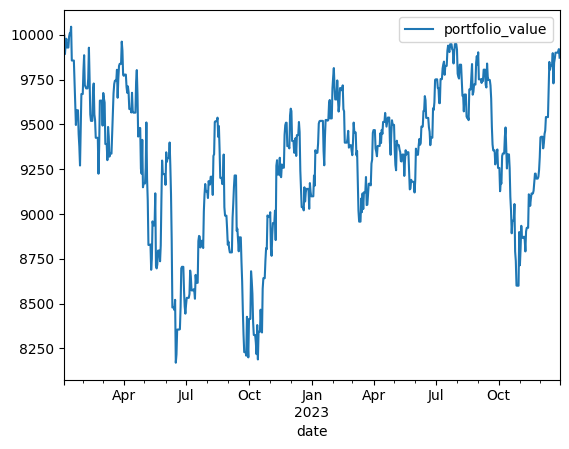

In [61]:
port2.reset_index().plot(x='date', y='portfolio_value')


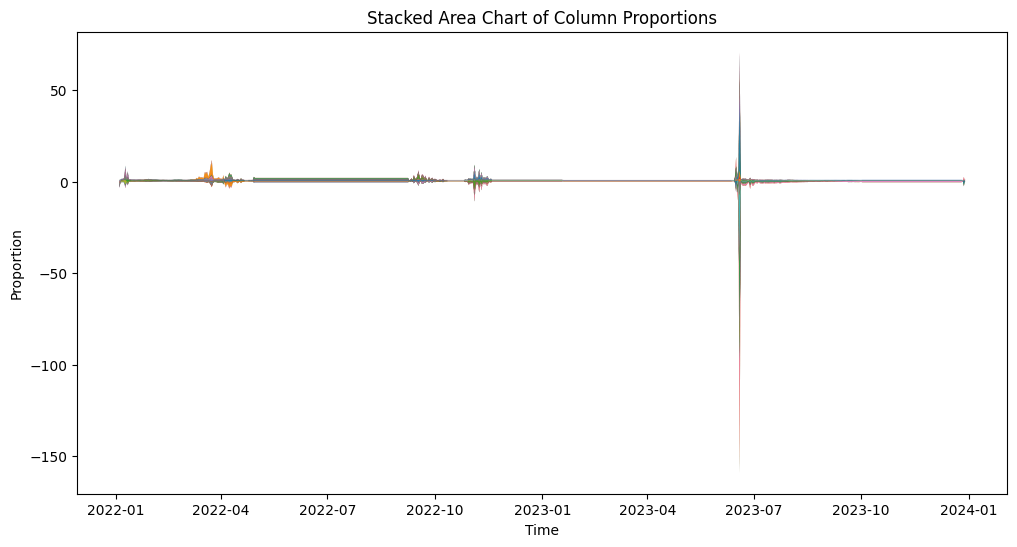

In [51]:

# Normalize to make proportions (row-wise sum = 1)
pos2 = pos2.div(pos2.sum(axis=1), axis=0)

# Define x-axis (e.g., time or index)
x = range(len(pos2))

# Plot stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(pos2.index, pos2.T, labels=pos2.columns, alpha=0.8)

# Optional: Add legend (limited to avoid clutter)
# ax.legend(loc='upper left', fontsize='small', ncol=5, frameon=False)

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Proportion")
ax.set_title("Stacked Area Chart of Column Proportions")

plt.show()

In [15]:
from datetime import date

In [22]:
pos2[pos2.index == datetime(2016, 6, 1)].T.sort_values(datetime(2016, 6, 1))

dt,2016-06-01
symbol,
A,0.000000
NRG,0.000000
NOW,0.000000
NOC,0.000000
NKE,0.000000
...,...
TSLA,0.062869
WBD,0.063513
AMZN,0.092253


<Axes: xlabel='date'>

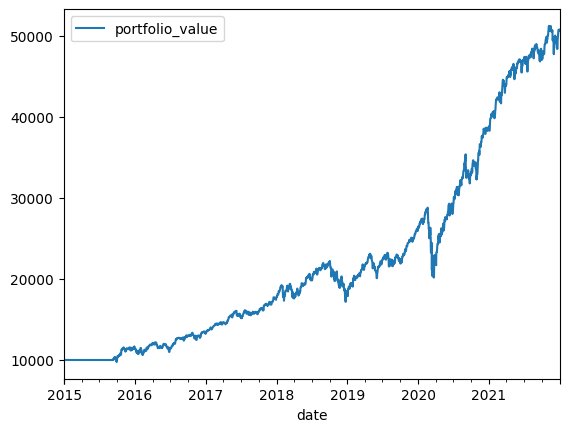

In [ ]:
port2.reset_index().plot(x='date', y='portfolio_value')

<Axes: xlabel='dt'>

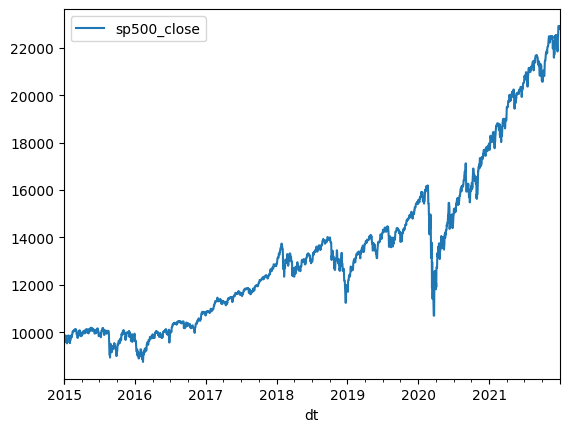

In [ ]:
t = df[['dt', 'sp500_close']].drop_duplicates('dt').copy()
t['sp500_close'] *= 10000/ t.sp500_close.iloc[0]
t.plot(x='dt', y='sp500_close')

<Axes: xlabel='date'>

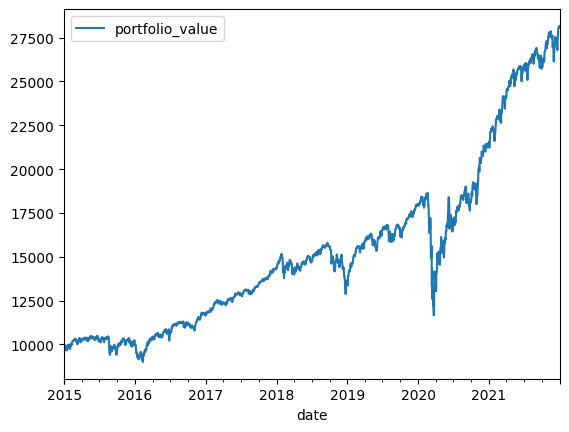

In [ ]:
port.reset_index().plot(x='date', y='portfolio_value')

In [62]:
sp = df.groupby(['dt']).agg({
    'ft_comments_90': 'mean',
    'ft_submissions_90': 'mean',
    'ft_news_90': 'mean',
    'ft_abs_comments_90': 'mean',
    'ft_abs_news_90': 'mean',
    'ft_comments_30': 'mean',
    'ft_news_30': 'mean',
    'ft_abs_comments_30': 'mean',
    'ft_abs_news_30': 'mean',
    'ft_comments_10': 'mean',
    'ft_abs_submissions_10': 'mean',
    'ft_abs_submissions_30': 'mean',
    'ft_submissions_10': 'mean',
    'ft_submissions_30': 'mean',
    'ft_news_10': 'mean',
    'ft_abs_comments_10': 'mean',
    'ft_abs_news_10': 'mean',
    'sp_tradeable_price': 'last',
    'sp_forward_returns_90': 'last',
    'sp_forward_returns_30': 'last',
    'sp_forward_returns_10': 'last',
}).reset_index()

In [63]:
for c in sp.columns:
    if c.startswith('ft_') and not c.endswith('r'):
        sp[f'{c}r'] = sp[c] - sp[c].rolling(90, min_periods=0).mean().fillna(0)

In [65]:
reduced = sp[::10]
pearsonr(reduced['ft_abs_submissions_10r'], reduced['sp_forward_returns_10'])
pearsonr(reduced['ft_submissions_10r'], reduced['sp_forward_returns_10'])
pearsonr(reduced['ft_abs_comments_10r'], reduced['sp_forward_returns_10'])

PearsonRResult(statistic=0.17101010141420456, pvalue=0.14801674250485708)

In [66]:
sp['combined'] = sp.ft_comments_10r

In [67]:
sp[sp.ft_news_10r > 0.04].sp_forward_returns_10.sum()

0.0

<Axes: xlabel='ft_abs_comments_10r', ylabel='sp_forward_returns_10'>

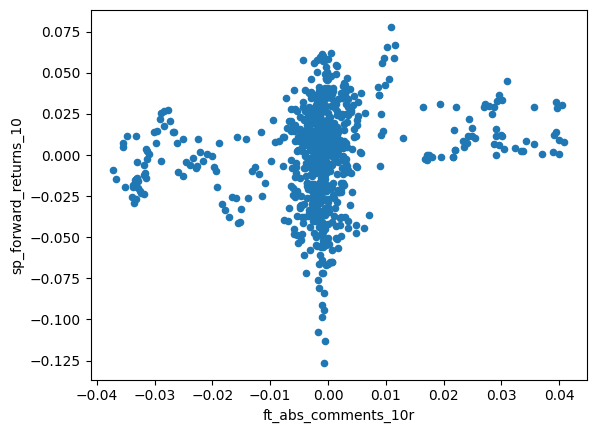

In [77]:
sp.plot(x='ft_abs_comments_10r', y='sp_forward_returns_10', kind='scatter')

In [73]:
sp['symbol'] = 'sp500'
sp['close'] = sp.sp_tradeable_price
sp['signal'] = 1
# sp['signal'] = np.where(sp.ft_abs_news_10r < 0.006, 1, -1)
# sp['signal'] = np.where(sp.ft_abs_submissions_10r + sp.ft_abs_comments_10r < 0.006, 1, -1)
sp['returns'] = np.where(sp.signal == 1, sp.sp_tradeable_price.shift(-1) / sp.sp_tradeable_price, 1)
sp['nav'] = 10000 * sp.returns.fillna(1).cumprod()


In [75]:
16*(sp.returns.fillna(1).mean() - 1) / (sp.returns.fillna(1) - 1).std()

0.07072073656663393

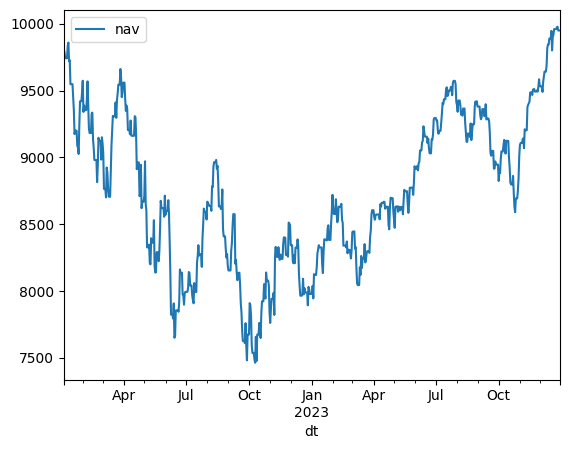

In [74]:
ax = sp.plot(x='dt', y='nav')
# sp.plot(x='dt', y='signal', ax=ax.twinx(), color='red')

,portfolio_value,cash,positions_value,transactions_cost,daily_return,cumulative_return
date,,,,,,
2014-12-29,10000.000000,10000.0,0.000000,0.0,NaN,NaN
2014-12-30,10000.000000,10000.0,0.000000,0.0,0.000000,0.000000
2014-12-31,10000.000000,10000.0,0.000000,0.0,0.000000,0.000000
2015-01-01,10000.000000,0.0,10000.000000,0.0,0.000000,0.000000
2015-01-02,9817.316101,0.0,9817.316101,0.0,-0.018268,-0.018268
...,...,...,...,...,...,...
2021-12-26,23278.592945,0.0,23278.592945,0.0,0.000000,1.327859
2021-12-27,23255.271597,0.0,23255.271597,0.0,-0.001002,1.325527
2021-12-28,23287.824313,0.0,23287.824313,0.0,0.001400,1.328782


<Axes: xlabel='date'>

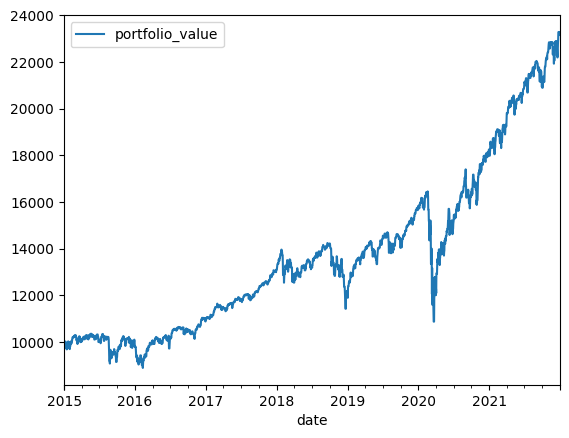

In [ ]:
port3, pos3 = simulate_portfolio_vectorized(sp, tc_rate=0)
port3.reset_index().plot(x='date', y='portfolio_value')

<Axes: xlabel='dt'>

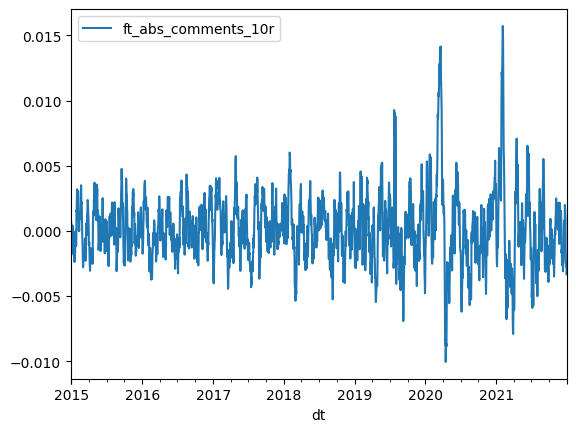

In [ ]:
sp.plot(x='dt', y='ft_abs_comments_10r')

In [ ]:
sp.signa

<Axes: xlabel='date'>

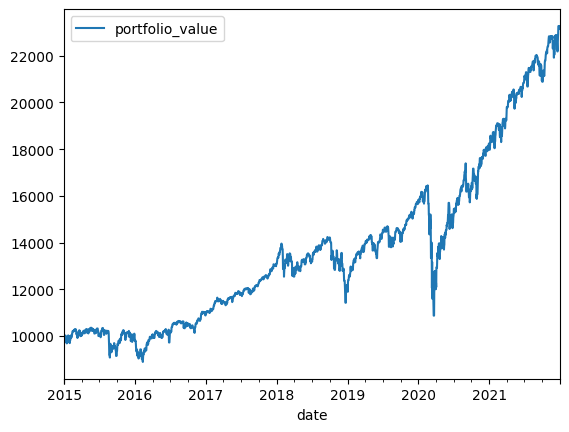

In [ ]:
sp[sp.ft_abs_comments_10r < 0.003].sp_forward_returns_10.mean()

0.004012609973506667

In [ ]:
sp['symbol'] = 

<Axes: xlabel='ft_abs_comments_10r', ylabel='sp_forward_returns_10'>

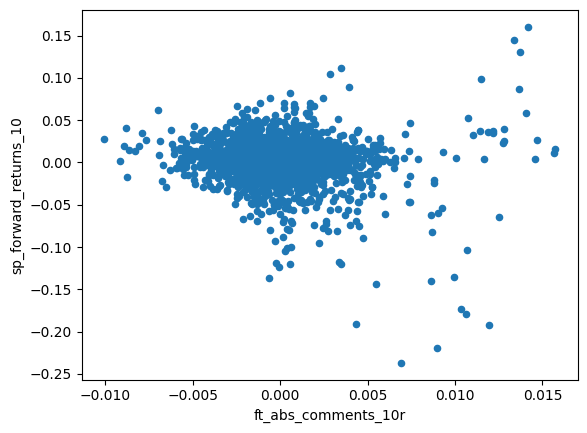

In [ ]:
sp.plot(x='ft_abs_comments_10r', y='sp_forward_returns_10', kind='scatter')

In [ ]:
sp.corr()

,dt,ft_comments_90,ft_news_90,ft_abs_comments_90,ft_abs_news_90,ft_comments_30,ft_news_30,ft_abs_comments_30,ft_abs_news_30,sp_tradeable_price,sp_forward_returns_90,sp_forward_returns_30
dt,1.000000,-0.559316,0.687606,0.953146,0.692072,-0.490748,0.691575,0.932832,0.698064,0.923112,0.218811,0.107915
ft_comments_90,-0.559316,1.000000,0.068173,-0.598836,0.057002,0.888605,0.036704,-0.588866,0.023776,-0.310217,-0.255273,-0.161192
ft_news_90,0.687606,0.068173,1.000000,0.674013,0.998570,0.086984,0.982318,0.656247,0.982304,0.847047,0.191688,0.111417
ft_abs_comments_90,0.953146,-0.598836,0.674013,1.000000,0.673496,-0.524862,0.678203,0.976476,0.679714,0.879975,0.280632,0.146488
ft_abs_news_90,0.692072,0.057002,0.998570,0.673496,1.000000,0.079269,0.981289,0.654470,0.984224,0.855408,0.192502,0.112396
ft_comments_30,-0.490748,0.888605,0.086984,-0.524862,0.079269,1.000000,0.084403,-0.541931,0.068332,-0.243747,-0.305798,-0.157715
ft_news_30,0.691575,0.036704,0.982318,0.678203,0.981289,0.084403,1.000000,0.657599,0.997672,0.831037,0.217012,0.127507
ft_abs_comments_30,0.932832,-0.588866,0.656247,0.976476,0.654470,-0.541931,0.657599,1.000000,0.656965,0.843275,0.297394,0.161202
ft_abs_news_30,0.698064,0.023776,0.982304,0.679714,0.984224,0.068332,0.997672,0.656965,1.000000,0.843321,0.217186,0.124888
sp_tradeable_price,0.923112,-0.310217,0.847047,0.879975,0.855408,-0.243747,0.831037,0.843275,0.843321,1.000000,0.081947,0.020058
